In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'C:/Users/s_csmscox/jupyterSave/dvc/train'
validation_dir = 'C:/Users/s_csmscox/jupyterSave/dvc/valid'


batch_size = 20

train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1, 
                                   horizontal_flip=True,
                                   vertical_flip=True)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['0', '1'],
    target_size=(224,224),                      
    batch_size=batch_size,     
    class_mode='categorical'                    
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['0', '1'],
    target_size=(224,224),                       
    batch_size=batch_size,    
    class_mode='categorical'                    
)


Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Feature Extraction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

np.random.seed(42)

# 모델 구축

# EfficientNetB0 모델 불러오기
pre_trained_model = EfficientNetB0(include_top=False, weights='imagenet',
                                  input_shape=(224, 224, 3))
pre_trained_model.trainable = False
pre_trained_model.summary()

# EfficientNetB0 모델에 덧붙이기
model = Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(2048, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))

model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              256905216 
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 271,445,669
Trainable params: 267,396,098
Non-trainable params: 4,049,571
__________________________________

In [3]:
#모델 학습
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

# 데이터 개수 / batch_size
steps_per_epoch = 15000 / batch_size
val_steps = 5000 / batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=7,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/7
750/750 [==============================] - 145s 194ms/step - loss: 0.5008 - accuracy: 0.7525 - val_loss: 0.1932 - val_accuracy: 0.9458
Epoch 2/7
750/750 [==============================] - 147s 196ms/step - loss: 0.2629 - accuracy: 0.8927 - val_loss: 0.1122 - val_accuracy: 0.9672
Epoch 3/7
750/750 [==============================] - 149s 199ms/step - loss: 0.2087 - accuracy: 0.9173 - val_loss: 0.0854 - val_accuracy: 0.9746
Epoch 4/7
750/750 [==============================] - 150s 200ms/step - loss: 0.1741 - accuracy: 0.9313 - val_loss: 0.0718 - val_accuracy: 0.9778
Epoch 5/7
750/750 [==============================] - 150s 200ms/step - loss: 0.1608 - accuracy: 0.9341 - val_loss: 0.0641 - val_accuracy: 0.9800
Epoch 6/7
750/750 [==============================] - 149s 199ms/step - loss: 0.1405 - accuracy: 0.9455 - val_loss: 0.0584 - val_accuracy: 0.9814
Epoch 7/7
750/750 [==============================] - 150s 200ms/step - loss: 0.1337 - accuracy: 0.9494 - val_loss: 0.0555 - val_ac

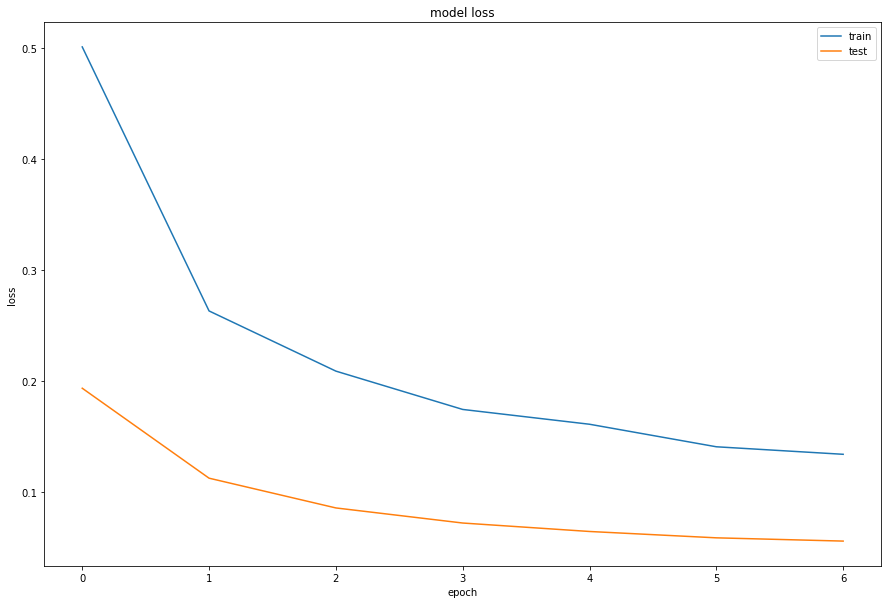

train loss= 0.133697971701622
validation loss= 0.05548238009214401


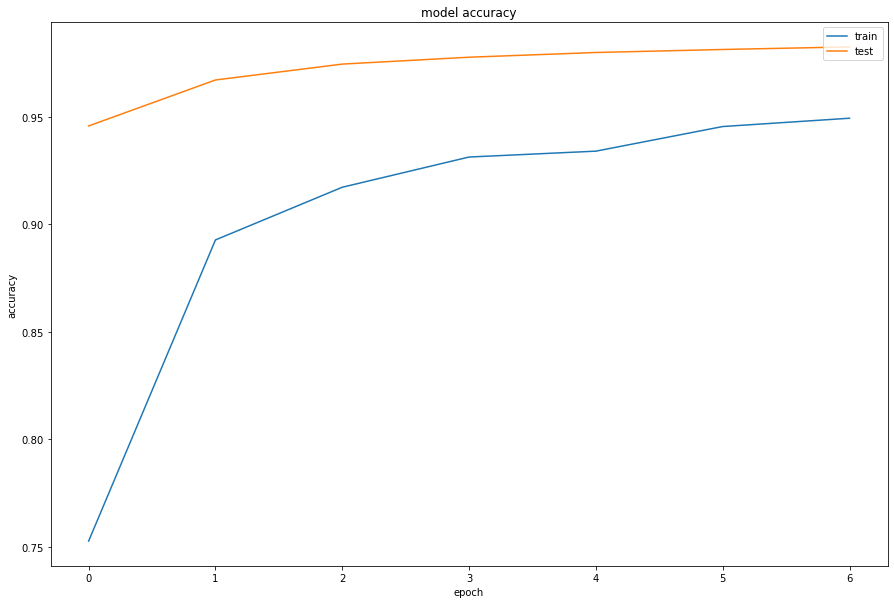

train accuracy= 0.949400007724762
validation accuracy= 0.9825999736785889


In [4]:
# 학습 곡선을 나타내는 함수
def plot_loss_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])
    
def plot_acc_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train accuracy=", history.history['accuracy'][-1])
    print("validation accuracy=", history.history['val_accuracy'][-1])
    
plot_loss_curve(history)
plot_acc_curve(history)

In [5]:
model.save('C:/Users/s_csmscox/jupyterSave/dvc/dvc_EfficientNetB0_224.h5')

In [2]:
import pathlib
import os,glob
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical

directory = 'C:/Users/s_csmscox/jupyterSave/dvc/test'
categories = ["0","1"] # dog = 1, cat = 0
nb_classes = len(categories)

w = 224
h = 224

X = []
y = []

for idx, obj in enumerate(categories):

    image_dir = directory + "/" + obj
    files = glob.glob(image_dir+"/*.jpg")
    print(obj, " 파일 길이 : ", len(files))
    
    for i, f in enumerate(files):
        img = Image.open(f)
        
        # 사이즈 조절
        img = img.resize((w, h))
        
        img = np.asarray(img)
        img = img.reshape(w,h,3)

        X.append(img)
        y.append(idx)

        if i % 10000 == 0:
            print(obj, " : ", f)
            
X_test = np.array(X)

y_test = np.array(y)
y_test = to_categorical(y_test)

0  파일 길이 :  2500
0  :  C:/Users/s_csmscox/jupyterSave/dvc/test/0\cat.7500.jpg
1  파일 길이 :  2500
1  :  C:/Users/s_csmscox/jupyterSave/dvc/test/1\dog.7500.jpg


In [3]:
# 모델 평가
print("-- Evaluate --")
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
157/157 [==============================] - 6s 41ms/step - loss: 0.0364 - accuracy: 0.9874
accuracy: 98.74%


# Fine Tuning

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('C:/Users/s_csmscox/jupyterSave/dvc/dvc_EfficientNetB0_224.h5')

In [3]:
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

np.random.seed(42)

# 모델 구축

# EfficientNetB0 모델 불러오기
pre_trained_model = EfficientNetB0(include_top=False, weights='imagenet',
                                  input_shape=(224, 224, 3))

set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'block6d_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# 일반적으로 learning_rate를 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-8), loss='categorical_crossentropy',
                metrics=['accuracy'])

#모델 학습
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

batch_size = 20

# 데이터 개수 / batch_size
steps_per_epoch = 15000 / batch_size
val_steps = 5000 / batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/100
750/750 [==============================] - 149s 199ms/step - loss: 0.0639 - accuracy: 0.9752 - val_loss: 0.0392 - val_accuracy: 0.9882
Epoch 2/100
750/750 [==============================] - 146s 195ms/step - loss: 0.0655 - accuracy: 0.9749 - val_loss: 0.0390 - val_accuracy: 0.9884
Epoch 3/100
750/750 [==============================] - 146s 195ms/step - loss: 0.0677 - accuracy: 0.9738 - val_loss: 0.0388 - val_accuracy: 0.9884
Epoch 4/100
750/750 [==============================] - 146s 195ms/step - loss: 0.0631 - accuracy: 0.9754 - val_loss: 0.0388 - val_accuracy: 0.9884
Epoch 5/100
750/750 [==============================] - 147s 196ms/step - loss: 0.0652 - accuracy: 0.9752 - val_loss: 0.0389 - val_accuracy: 0.9884
Epoch 6/100
750/750 [==============================] - 146s 195ms/step - loss: 0.0633 - accuracy: 0.9749 - val_loss: 0.0389 - val_accuracy: 0.9884
Epoch 7/100
750/750 [==============================] - 146s 195ms/step - loss: 0.0612 - accuracy: 0.9759 - val_loss: 0

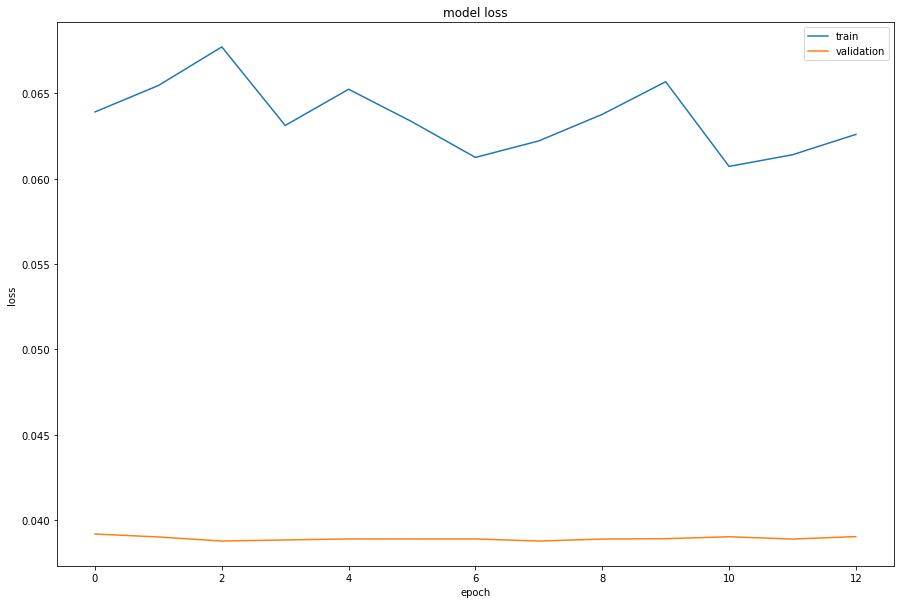

train loss= 0.06258970499038696
validation loss= 0.039034392684698105


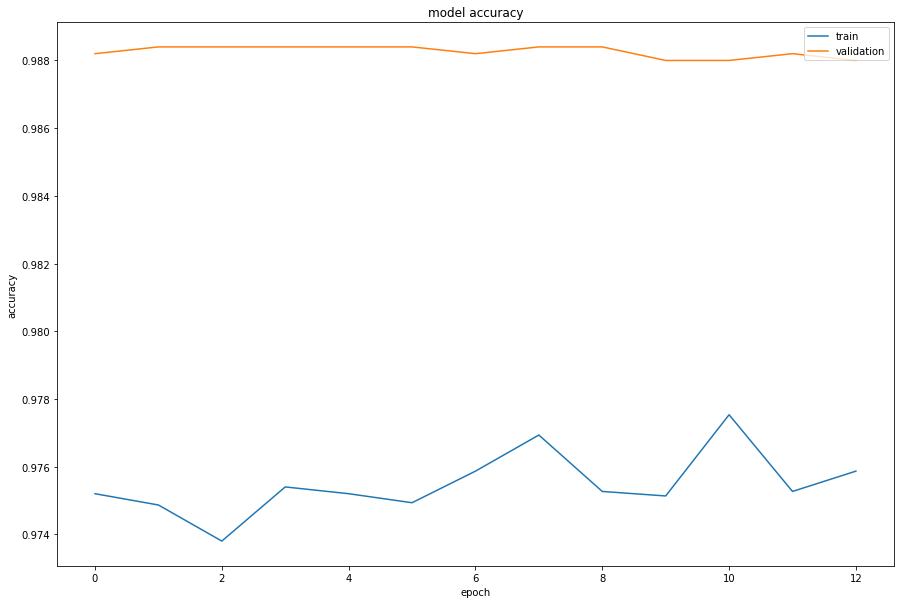

train accuracy= 0.9758666753768921
validation accuracy= 0.9879999756813049


In [4]:
# 학습 곡선을 나타내는 함수
def plot_loss_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()   
    
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])
    
def plot_acc_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()   
    
    print("train accuracy=", history.history['accuracy'][-1])
    print("validation accuracy=", history.history['val_accuracy'][-1])

plot_loss_curve(history)
plot_acc_curve(history)

In [5]:
model.save('C:/Users/s_csmscox/jupyterSave/dvc/dvc_EfficientNetB0_FT_224.h5')

In [6]:
import pathlib
import os,glob
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical

directory = 'C:/Users/s_csmscox/jupyterSave/dvc/test'
categories = ["0","1"] # dog = 1, cat = 0
nb_classes = len(categories)

w = 224
h = 224

X = []
y = []

for idx, obj in enumerate(categories):

    image_dir = directory + "/" + obj
    files = glob.glob(image_dir+"/*.jpg")
    print(obj, " 파일 길이 : ", len(files))
    
    for i, f in enumerate(files):
        img = Image.open(f)
        
        # 사이즈 조절
        img = img.resize((w, h))
        
        img = np.asarray(img)
        img = img.reshape(w,h,3)

        X.append(img)
        y.append(idx)

        if i % 10000 == 0:
            print(obj, " : ", f)
            
X_test = np.array(X)

y_test = np.array(y)
y_test = to_categorical(y_test)

0  파일 길이 :  2500
0  :  C:/Users/s_csmscox/jupyterSave/dvc/test/0\cat.7500.jpg
1  파일 길이 :  2500
1  :  C:/Users/s_csmscox/jupyterSave/dvc/test/1\dog.7500.jpg


In [7]:
# 모델 평가
print("-- Evaluate --")
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
157/157 [==============================] - 6s 39ms/step - loss: 0.0364 - accuracy: 0.9874
accuracy: 98.74%
